# Isolation Forest

## Import Data

In [11]:
import pandas as pd

train_df = pd.read_csv("../data/processed_train_df.csv")
print(train_df.shape)

test_df = pd.read_csv("../data/processed_test_df.csv")
print(test_df.shape)

df = pd.concat([train_df, test_df])
print(df.shape)

(227845, 31)
(56962, 31)
(284807, 31)


In [12]:
# Exclude labels

y_train = train_df['Class']
X_train = train_df.drop(columns=['Class'])

X_train.columns

y_test = test_df['Class']
X_test = test_df.drop(columns=['Class'])

labels = df['Class']
df_unlabelled = df.drop(columns=['Class'])

## Model Building

In [13]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    n_estimators=300,
    max_samples="auto",
    contamination=0.0015,  # expected proportion of anomalies; tune later - decided by quick online research
    random_state=42,
    n_jobs=-1
)

iso.fit(X_train)

IsolationForest(contamination=0.0015, n_estimators=300, n_jobs=-1,
                random_state=42)

In [14]:
raw_scores = iso.score_samples(X_test)

anomaly_scores = -raw_scores

pred_labels = (iso.predict(X_test) == -1).astype(int)

results = pd.DataFrame({
    "anomaly_score": anomaly_scores,
    "predicted_label": pred_labels,
    "true_label": y_test  # only for later evaluation
}, index=X_test.index)

results.head()

,anomaly_score,predicted_label,true_label
0,0.402470,0,0
1,0.483837,0,0
2,0.543463,0,0
3,0.363384,0,0
4,0.437474,0,0


In [15]:
import numpy as np

cutoff = np.quantile(anomaly_scores, 0.985)
print(cutoff.round(4))

0.561


ROC AUC: 0.9538
PR AUC: 0.1522


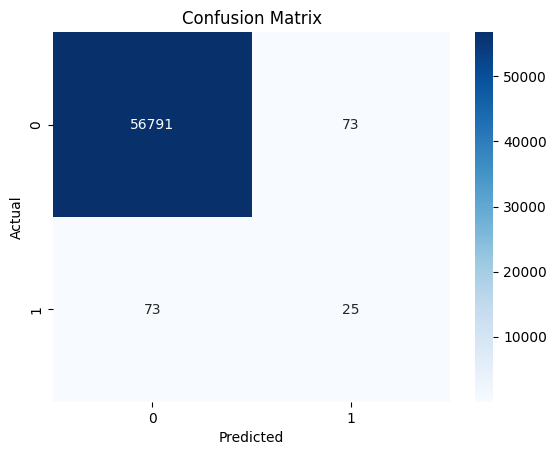

In [16]:
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

roc = roc_auc_score(y_test, anomaly_scores)
pr_auc = average_precision_score(y_test, anomaly_scores)
cm = confusion_matrix(y_test, pred_labels)

print(f"ROC AUC: {roc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, pred_labels), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

So, we can see that this model does not perform particularly well, especially when compared to the 0.76 PR AUC of our quick Logistic Regression model from EDA. Let's try tuning it.

## Hyperparameter Tuning

In [17]:
def precision_recall_at_k(y_true, scores, k=0.01):
    """
    Compute Precision@k and Recall@k for anomaly scores.
    y_true: array-like of shape (n,) with 0/1 labels
    scores: array-like of shape (n,) with higher = more anomalous
    k: fraction of samples to flag (e.g. 0.01 = top 1%)
    """
    n = len(scores)
    top_n = max(1, int(np.ceil(k * n)))  # at least one sample

    # Get indices of top-k scores
    idx = np.argsort(-scores)[:top_n]

    # Precision = frauds / flagged
    precision = y_true.iloc[idx].mean()

    # Recall = frauds caught / total frauds
    recall = y_true.iloc[idx].sum() / y_true.sum()

    return precision, recall

In [26]:
from sklearn.model_selection import ParameterGrid

def tune_IF(param_grid, PRIMARY, SECONDARY, X_test=X_test, y_test=y_test):

    runs = []
    best_tuple = (-np.inf, -np.inf)  # (primary, secondary)
    best_params = None
    best_model = None
    best_scores = None

    for params in ParameterGrid(param_grid):
        iso = IsolationForest(max_features=1, random_state=42, n_jobs=-1, **params) # Used param_grid to work out max_features = 1 is optimal
        iso.fit(X_train)

        scores = -iso.score_samples(X_test)

        roc = roc_auc_score(y_test, scores)
        pr_auc = average_precision_score(y_test, scores)
        p_at_1, r_at_1 = precision_recall_at_k(y_test, scores, k=0.01)
        p_at_05, r_at_05 = precision_recall_at_k(y_test, scores, k=0.005)

        runs.append({**params, "ROC": roc, "pr_auc": pr_auc, "p_at_1": p_at_1, "r_at_1": r_at_1, "p_at_05": p_at_05, "r_at_05": r_at_05})

        primary_val = r_at_1 if PRIMARY == "r_at_1" else pr_auc
        secondary_val = pr_auc if SECONDARY == "pr_auc" else r_at_1
        cand_tuple = (primary_val, secondary_val)

        if cand_tuple > best_tuple:
            best_tuple = cand_tuple
            best_params = params
            best_model = iso
            best_scores = scores

    results_df = pd.DataFrame(runs).sort_values(
        by=[PRIMARY, SECONDARY], ascending=[False, False]
    ).reset_index(drop=True)

    print("Top configs:")
    display(results_df.head(20))
    print("\nSelected params:", best_params)
    print(f"Selected {PRIMARY}={best_tuple[0]:.4f}, {SECONDARY}={best_tuple[1]:.4f}")

    return(best_tuple, best_params, best_model, best_scores)

In [24]:
PRIMARY = "r_at_1"
SECONDARY = "pr_auc"

# Note that I have already narrowed down the param_grid through multiple iterations

param_grid = {
    "n_estimators": [400, 500, 600],
    "max_samples": [3072, 4096, 5120],
    "bootstrap": [False, True],
    # Note: intentionally not tuning 'contamination' here
}

tune_IF(param_grid, PRIMARY, SECONDARY)

Top configs:


,bootstrap,max_samples,n_estimators,ROC,pr_auc,p_at_1,r_at_1,p_at_05,r_at_05
0,True,4096,500,0.951356,0.254046,0.124561,0.724490,0.192982,0.561224
1,True,4096,400,0.951046,0.249886,0.124561,0.724490,0.192982,0.561224
2,True,5120,600,0.948125,0.245399,0.124561,0.724490,0.178947,0.520408
3,True,4096,600,0.951181,0.254707,0.122807,0.714286,0.189474,0.551020
4,True,5120,500,0.949257,0.250248,0.122807,0.714286,0.182456,0.530612
5,True,5120,400,0.949253,0.249883,0.122807,0.714286,0.185965,0.540816
6,False,5120,500,0.951684,0.256555,0.121053,0.704082,0.192982,0.561224
7,False,5120,400,0.951567,0.256391,0.121053,0.704082,0.192982,0.561224
8,True,3072,500,0.951413,0.256315,0.121053,0.704082,0.182456,0.530612
9,False,5120,600,0.951482,0.255515,0.121053,0.704082,0.192982,0.561224



Selected params: {'bootstrap': True, 'max_samples': 4096, 'n_estimators': 500}
Selected r_at_1=0.7245, pr_auc=0.2540


((0.7244897959183674, 0.25404633106508606),
 {'bootstrap': True, 'max_samples': 4096, 'n_estimators': 500},
 IsolationForest(bootstrap=True, max_features=1, max_samples=4096,
                 n_estimators=500, n_jobs=-1, random_state=42),
 array([0.44000145, 0.46177124, 0.48602979, ..., 0.43635305, 0.42253589,
        0.42312922]))

Now let's try out some of the best parameters on the test set to see how effective they are on the whole dataset.

## Validation

In [28]:
def validate_IF(param_grid, PRIMARY, SECONDARY, X_test=df_unlabelled, y_test=labels):

    return tune_IF(param_grid, PRIMARY, SECONDARY, X_test, y_test)

PRIMARY = "r_at_1"
SECONDARY = "pr_auc"

# Note that I have already narrowed down the param_grid through multiple iterations

param_grid = {
    "n_estimators": [400, 500, 600],
    "max_samples": [3072, 4096, 5120],
    "bootstrap": [False, True],
    # Note: intentionally not tuning 'contamination' here
}

validate_IF(param_grid, PRIMARY, SECONDARY)

Top configs:


,bootstrap,max_samples,n_estimators,ROC,pr_auc,p_at_1,r_at_1,p_at_05,r_at_05
0,False,5120,600,0.945589,0.241527,0.114426,0.662602,0.180351,0.522358
1,True,4096,500,0.948059,0.240779,0.114075,0.660569,0.181053,0.524390
2,True,4096,600,0.947024,0.238009,0.114075,0.660569,0.178947,0.518293
3,True,4096,400,0.947488,0.234578,0.114075,0.660569,0.178947,0.518293
4,True,5120,600,0.946432,0.233266,0.114075,0.660569,0.177544,0.514228
5,False,5120,500,0.945856,0.244157,0.113373,0.656504,0.178947,0.518293
6,False,5120,400,0.945553,0.242472,0.113022,0.654472,0.180351,0.522358
7,True,5120,500,0.947182,0.235974,0.112671,0.652439,0.178246,0.516260
8,False,4096,600,0.948075,0.236263,0.112320,0.650407,0.178947,0.518293
9,True,5120,400,0.947570,0.233796,0.112320,0.650407,0.176842,0.512195



Selected params: {'bootstrap': False, 'max_samples': 5120, 'n_estimators': 600}
Selected r_at_1=0.6626, pr_auc=0.2415


((0.6626016260162602, 0.2415266316984472),
 {'bootstrap': False, 'max_samples': 5120, 'n_estimators': 600},
 IsolationForest(max_features=1, max_samples=5120, n_estimators=600, n_jobs=-1,
                 random_state=42),
 array([0.4321302 , 0.42192052, 0.46422931, ..., 0.43185201, 0.41885989,
        0.42263483]))

Our tuned Isolation Forest achieved ROC AUC = 0.95 and PR AUC = 0.24.

At a 1% review budget, this corresponds to 11% precision and 66% recall, a 66× improvement over random guessing.
In practice, this means fraud investigators could catch ~320 frauds (two-thirds of all fraud cases) while only reviewing 1% of total transactions.

At a 0.5% review budget, this corresponds to 18% precision and 52% recall, a 104× improvement over random guessing.
In practice, this means fraud investigators could catch ~255 frauds (just over half of all fraud cases) while only reviewing 0.5% of total transactions.

In [ ]:
# Note: It is probably worth looking at why there is such a drop off in recall at 1% on the test set vs the whole dataset.

## Reducing Model Complexity

In practice, it is feasible that increased PR AUC is not deemed to be worth the extra computational cost that comes with it, as only the top x% of transactions flagged as 'most suspicious' will be manually reviewed.  
In this case, can we simplify the model so that it runs more efficiently, whilst maintaining good p_at_1 and r_at_1 scores?  
Note that this assumes that the top 1% of transactions will be reviewed. Of course, if the percentage differs from 1% that would affect the necessary complexity of the model to retain performance.

In [29]:
PRIMARY = "r_at_1"
SECONDARY = "pr_auc"

# Note that I have already narrowed down the param_grid through multiple iterations

param_grid = {
    "n_estimators": [300, 400, 500],
    "max_samples": [512, 1024, 2048],
    "bootstrap": [False, True],
    # Note: intentionally not tuning 'contamination' here
}

tune_IF(param_grid, PRIMARY, SECONDARY)

Top configs:


,bootstrap,max_samples,n_estimators,ROC,pr_auc,p_at_1,r_at_1,p_at_05,r_at_05
0,True,1024,500,0.949611,0.246927,0.122807,0.714286,0.182456,0.530612
1,False,1024,500,0.949668,0.244432,0.122807,0.714286,0.182456,0.530612
2,False,2048,500,0.951602,0.253932,0.121053,0.704082,0.178947,0.520408
3,False,2048,300,0.952530,0.252770,0.121053,0.704082,0.182456,0.530612
4,True,2048,500,0.951178,0.251818,0.121053,0.704082,0.178947,0.520408
5,False,2048,400,0.950611,0.251184,0.121053,0.704082,0.185965,0.540816
6,True,2048,400,0.950076,0.249435,0.121053,0.704082,0.185965,0.540816
7,True,1024,300,0.949982,0.244781,0.121053,0.704082,0.175439,0.510204
8,True,1024,400,0.949156,0.243233,0.121053,0.704082,0.182456,0.530612
9,False,1024,300,0.949831,0.241306,0.121053,0.704082,0.175439,0.510204



Selected params: {'bootstrap': True, 'max_samples': 1024, 'n_estimators': 500}
Selected r_at_1=0.7143, pr_auc=0.2469


((0.7142857142857143, 0.24692654033227998),
 {'bootstrap': True, 'max_samples': 1024, 'n_estimators': 500},
 IsolationForest(bootstrap=True, max_features=1, max_samples=1024,
                 n_estimators=500, n_jobs=-1, random_state=42),
 array([0.44779068, 0.48127543, 0.51621728, ..., 0.43898377, 0.42581122,
        0.4321898 ]))

In [30]:
validate_IF(param_grid, PRIMARY, SECONDARY)

Top configs:


,bootstrap,max_samples,n_estimators,ROC,pr_auc,p_at_1,r_at_1,p_at_05,r_at_05
0,True,2048,500,0.946086,0.237263,0.111969,0.648374,0.174035,0.504065
1,False,2048,500,0.946577,0.236902,0.111969,0.648374,0.173333,0.502033
2,False,2048,300,0.946597,0.236156,0.111618,0.646341,0.174737,0.506098
3,True,1024,500,0.945790,0.231643,0.111618,0.646341,0.174737,0.506098
4,False,1024,500,0.946113,0.230656,0.111618,0.646341,0.174035,0.504065
5,False,1024,400,0.945729,0.227947,0.111618,0.646341,0.174737,0.506098
6,False,1024,300,0.945625,0.226303,0.111618,0.646341,0.168421,0.487805
7,True,2048,400,0.945665,0.233452,0.111267,0.644309,0.176140,0.510163
8,False,2048,400,0.946227,0.231924,0.111267,0.644309,0.176140,0.510163
9,True,1024,400,0.945354,0.229338,0.111267,0.644309,0.174737,0.506098



Selected params: {'bootstrap': True, 'max_samples': 2048, 'n_estimators': 500}
Selected r_at_1=0.6484, pr_auc=0.2373


((0.6483739837398373, 0.23726276401612179),
 {'bootstrap': True, 'max_samples': 2048, 'n_estimators': 500},
 IsolationForest(bootstrap=True, max_features=1, max_samples=2048,
                 n_estimators=500, n_jobs=-1, random_state=42),
 array([0.43000212, 0.42769133, 0.47371162, ..., 0.43189477, 0.42377308,
        0.42540123]))

We can see that reducing the model complexity, we are still able to retain strong p_at_1 and r_at_1 values whilst reducing model complexity.

From the above, we can reduce as far as n_neighbors = 300, max_samples = 1024 before we start seeing meaningful drop offs in performance on the top 1% of suspicious transactions.